In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from pathlib import Path
import shutil

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c datathonindoml-2022

Saving kaggle.json to kaggle.json
 99% 1.50G/1.51G [00:09<00:00, 184MB/s]
100% 1.51G/1.51G [00:09<00:00, 177MB/s]


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [ ]:
local_zip = '/content/datathonindoml-2022.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [ ]:
base_dir = '/content/data'
train_dir = os.path.join(base_dir, 'train/train')
valid_dir = os.path.join(base_dir, 'validation/validation')

In [ ]:
classes = {
    0:'memo',
    1:'form',
    2:'email',
    3:'handwritten',
    4:'advertisement',
    5:'scientific_report',
    6:'scientific_publication',
    7:'specification',
    8:'file_folder',
    9:'news_article',
    10:'budget',
    11:'invoice',
    12:'presentation',
    13:'questionaire',
    14:'resume',
    15:'letter'
}

In [ ]:
for (key,value) in classes.items():
  path = os.path.join(train_dir, value)
  os.mkdir(path)

In [ ]:
train_labels = pd.read_csv(base_dir+'/train_labels.csv')
train_labels.head(5)

,id,label
0,0,1
1,1,13
2,2,13
3,3,14
4,4,6


In [ ]:
def push_to_dir(key, value, dir):
  file_ids = train_labels[train_labels['label']==key]['id'].values
  for file_id in file_ids:
    shutil.move(os.path.join(dir,str(file_id))+'.tif', os.path.join(os.path.join(dir,value),str(file_id))+'.tif')

for key,value in classes.items():
  push_to_dir(key,value,train_dir)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        color_mode='rgb',
        class_mode='categorical',
        subset='training')

Found 11207 images belonging to 16 classes.


In [ ]:
valid_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        color_mode='rgb',
        class_mode='categorical',
        subset='validation')

Found 4793 images belonging to 16 classes.



Class Type = specification, filename = 15169.tif


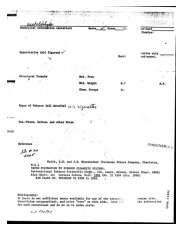


Class Type = advertisement, filename = 11297.tif


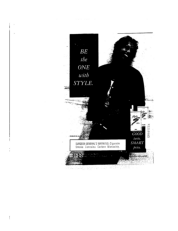


Class Type = handwritten, filename = 11330.tif


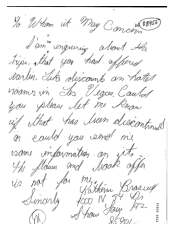


Class Type = presentation, filename = 11962.tif


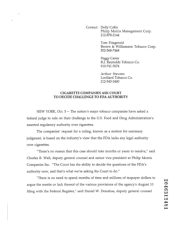


Class Type = resume, filename = 2691.tif


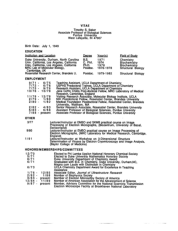


Class Type = file_folder, filename = 2229.tif


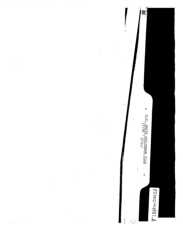


Class Type = letter, filename = 6589.tif


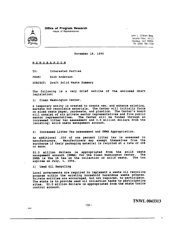


Class Type = scientific_publication, filename = 5377.tif


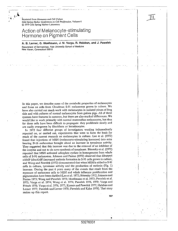


Class Type = memo, filename = 4264.tif


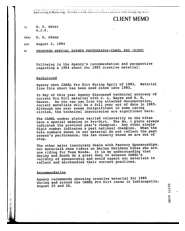


Class Type = scientific_report, filename = 12879.tif


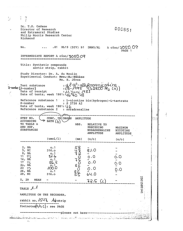


Class Type = questionaire, filename = 9909.tif


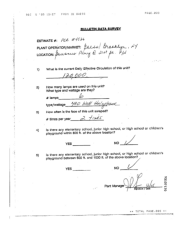


Class Type = email, filename = 11149.tif


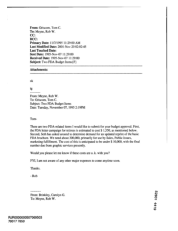


Class Type = invoice, filename = 14558.tif


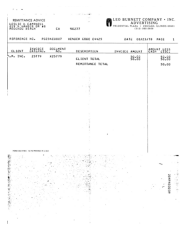


Class Type = news_article, filename = 11870.tif


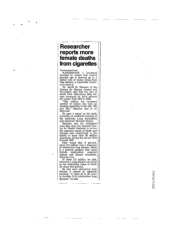


Class Type = form, filename = 5826.tif


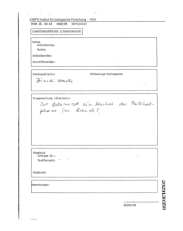


Class Type = budget, filename = 13710.tif


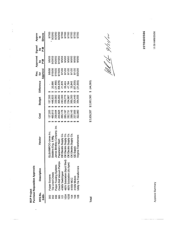

In [ ]:
train_classes_dir = os.listdir(train_dir)

for label in train_classes_dir:
  i = 1
  path = os.path.join(train_dir, label)
  fname = os.listdir(path)[0]
  image = cv2.imread(os.path.join(path,fname))
  print(f'\nClass Type = {label}, filename = {fname}')
  plt.axis('off')
  plt.imshow(image)
  plt.show()

In [ ]:
def GoogleNet(classes):
  from keras.applications.inception_v3 import InceptionV3
  base_model = InceptionV3(input_shape = (224,224,3), weights='imagenet', include_top=False)
  base_model.trainable = False
  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(name='GlobalAvgPooling_Layer'),
    tf.keras.layers.Dropout(0.4, name='Dropout_Layer'),
    tf.keras.layers.Dense(classes, activation='softmax', name='Output_Layer')
  ])

  model.summary()

  model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001, momentum=0.9), metrics = ['accuracy'])
  return model

In [ ]:
def lr_scheduler(epoch):
  return 0.01*(1-(epoch/60.0))**0.5

In [ ]:
googlenet_model = GoogleNet(classes = 16)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 GlobalAvgPooling_Layer (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 Dropout_Layer (Dropout)     (None, 2048)              0         
                                                                 
 Output_Layer (Dense)        (None, 16)                32784     
                                                                 
Total params: 21,835,568
Trainable params: 32,784
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
googlenet_history = googlenet_model.fit(train_generator, epochs=40, validation_data = valid_generator,verbose = 1, callbacks=[callbacks])

Epoch 1/40
351/351 [==============================] - 131s 362ms/step - loss: 2.4466 - accuracy: 0.2312 - val_loss: 2.0600 - val_accuracy: 0.4185
Epoch 2/40
351/351 [==============================] - 126s 360ms/step - loss: 2.0205 - accuracy: 0.3858 - val_loss: 1.8326 - val_accuracy: 0.4711
Epoch 3/40
351/351 [==============================] - 126s 359ms/step - loss: 1.8569 - accuracy: 0.4254 - val_loss: 1.7118 - val_accuracy: 0.4893
Epoch 4/40
351/351 [==============================] - 126s 359ms/step - loss: 1.7559 - accuracy: 0.4579 - val_loss: 1.6450 - val_accuracy: 0.5005
Epoch 5/40
351/351 [==============================] - 126s 359ms/step - loss: 1.6905 - accuracy: 0.4776 - val_loss: 1.5959 - val_accuracy: 0.5116
Epoch 6/40
351/351 [==============================] - 126s 360ms/step - loss: 1.6458 - accuracy: 0.4866 - val_loss: 1.5524 - val_accuracy: 0.5249
Epoch 7/40
351/351 [==============================] - 126s 359ms/step - loss: 1.6064 - accuracy: 0.5018 - val_loss: 1.5221 -

In [ ]:
schedule = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
googlenet_history = googlenet_model.fit(googlenet_model.fit(train_generator, epochs=60, validation_data = valid_generator,verbose = 1, callbacks=[schedule]))

Epoch 1/60
351/351 [==============================] - 70s 190ms/step - loss: 2.1323 - accuracy: 0.3992 - val_loss: 1.7245 - val_accuracy: 0.4941 - lr: 0.0100
Epoch 2/60
351/351 [==============================] - 65s 185ms/step - loss: 1.9736 - accuracy: 0.4564 - val_loss: 1.9100 - val_accuracy: 0.4728 - lr: 0.0099
Epoch 3/60
351/351 [==============================] - 65s 184ms/step - loss: 1.9369 - accuracy: 0.4797 - val_loss: 1.7385 - val_accuracy: 0.5011 - lr: 0.0098
Epoch 4/60
351/351 [==============================] - 65s 184ms/step - loss: 1.8558 - accuracy: 0.4876 - val_loss: 1.6386 - val_accuracy: 0.5402 - lr: 0.0097
Epoch 5/60
351/351 [==============================] - 65s 185ms/step - loss: 1.8517 - accuracy: 0.4965 - val_loss: 1.7339 - val_accuracy: 0.5132 - lr: 0.0097
Epoch 6/60
351/351 [==============================] - 65s 185ms/step - loss: 1.8111 - accuracy: 0.5041 - val_loss: 1.8113 - val_accuracy: 0.5047 - lr: 0.0096
Epoch 7/60
351/351 [==============================] 

In [ ]:
def visualise_train(history):
  sns.set_style("darkgrid")
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)



  #Train and validation loss
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel('Epoch #')
  plt.ylabel('loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
visualise_train(googlenet_history)